#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import mlflow
import mlflow.keras

In [2]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [4]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [5]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [6]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비

In [7]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [8]:
exp_id = mlflow.create_experiment("exp4")
exp_id

'3'

## 2 데이터 살펴보기

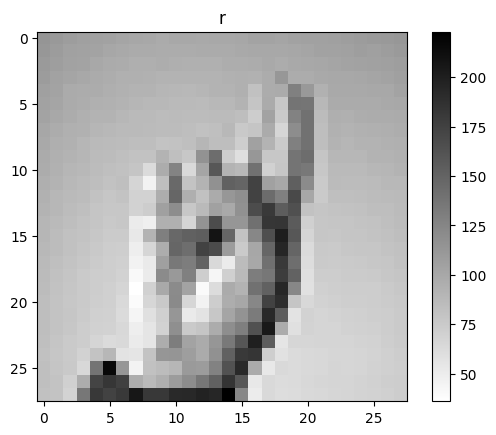

In [9]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [10]:
x = data.drop("label",axis=1)
y = data["label"]

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=1000,random_state=42,stratify=y)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=2000,random_state=42,stratify=y_train)

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [12]:
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [14]:
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [21]:
x_train2 = x_train/255
x_val2 = x_val/255
x_test2 = x_test/255

## 4.모델링

### (1) 모델1

In [22]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    
    keras.backend.clear_session()

    il = keras.layers.Input(shape=(28,28,1))
    cl = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same",activation="relu")(il)
    bl = keras.layers.BatchNormalization()(cl)
    cl2 = keras.layers.Conv2D(filters=32,kernel_size=(2,2),padding="valid",activation="relu")(bl)
    bl2 = keras.layers.BatchNormalization()(cl2)
    cl3 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(bl2)
    bl3 = keras.layers.BatchNormalization()(cl3)
    pl = keras.layers.MaxPool2D(pool_size=(2,2))(bl3)
    cl4 = keras.layers.Conv2D(filters=80,kernel_size=(3,3),padding="same",activation="relu")(pl)
    bl4 = keras.layers.BatchNormalization()(cl4)
    cl5 = keras.layers.Conv2D(filters=192,kernel_size=(2,2),padding="valid",activation="relu")(bl4)
    pl2 = keras.layers.MaxPool2D(pool_size=(2,2))(cl5)

    a = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(pl2)
    a2 = keras.layers.BatchNormalization()(a)
    a3 = keras.layers.Conv2D(filters=96,kernel_size=(3,3),padding="same",activation="relu")(a2)
    a4 = keras.layers.BatchNormalization()(a3)
    a5 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(a4)
    a6 = keras.layers.BatchNormalization()(a5)

    b = keras.layers.Conv2D(filters=48,kernel_size=(3,3),padding="same",activation="relu")(pl2)
    b2 = keras.layers.BatchNormalization()(b)
    b3 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(b2)
    b4 = keras.layers.BatchNormalization()(b3)

    c = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(1,1),padding="same")(pl2)
    c2 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(c)
    c3 = keras.layers.BatchNormalization()(c2)

    d = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(pl2)
    d2 = keras.layers.BatchNormalization()(d)

    Add = keras.layers.Add()([a6,b4,c3,d2])
    con = keras.layers.Concatenate()([a6,b4,c3,d2])

    con2 = keras.layers.Concatenate()([Add,con])

    aver = keras.layers.GlobalAveragePooling2D()(con2)

    ol = keras.layers.Dense(26,activation = "softmax")(aver)

    model = keras.models.Model(il,ol)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"],optimizer="adam")
    
    es = EarlyStopping(monitor = "val_loss",min_delta=0,patience = 5,verbose=1,restore_best_weights=True)
    history=model.fit(x_train2,y_train,validation_split=0.2,verbose=1,epochs=30,callbacks=[es])
    
    y_pred = model.predict(x_val2).argmax(axis=1)
    acc = accuracy_score(y_val,y_pred)
    mlflow.log_metric("accuracy", acc)
    mlflow.keras.log_model(model, "keras_sign_language",  registered_model_name="DL_sign_language")
    mlflow.keras.autolog(disable = True)

Epoch 1/30
125/125 [==============================] - 7s 32ms/step - loss: 0.7956 - accuracy: 0.7810 - val_loss: 3.6739 - val_accuracy: 0.0370
Epoch 2/30
125/125 [==============================] - 4s 31ms/step - loss: 0.0548 - accuracy: 0.9898 - val_loss: 4.1966 - val_accuracy: 0.0700
Epoch 3/30
125/125 [==============================] - 4s 31ms/step - loss: 0.0093 - accuracy: 0.9998 - val_loss: 2.6689 - val_accuracy: 0.2520
Epoch 4/30
125/125 [==============================] - 4s 29ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3958 - val_accuracy: 0.9030
Epoch 5/30
125/125 [==============================] - 4s 29ms/step - loss: 9.0982e-04 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9960
Epoch 6/30
125/125 [==============================] - 4s 29ms/step - loss: 6.0774e-04 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9990
Epoch 7/30
125/125 [==============================] - 4s 30ms/step - loss: 4.9378e-04 - accuracy: 1.0000 - val_loss: 0.0058 - val_accu

INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp88v6ru05\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp88v6ru05\model\data\model\assets


63/63 [==============================] - 1s 9ms/step


2023/05/18 15:15:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp654jeiam\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp654jeiam\model\data\model\assets
Registered model 'DL_sign_language' already exists. Creating a new version of this model...
2023/05/18 15:15:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL_sign_language, version 2
Created version '2' of model 'DL_sign_language'.


* 학습곡선

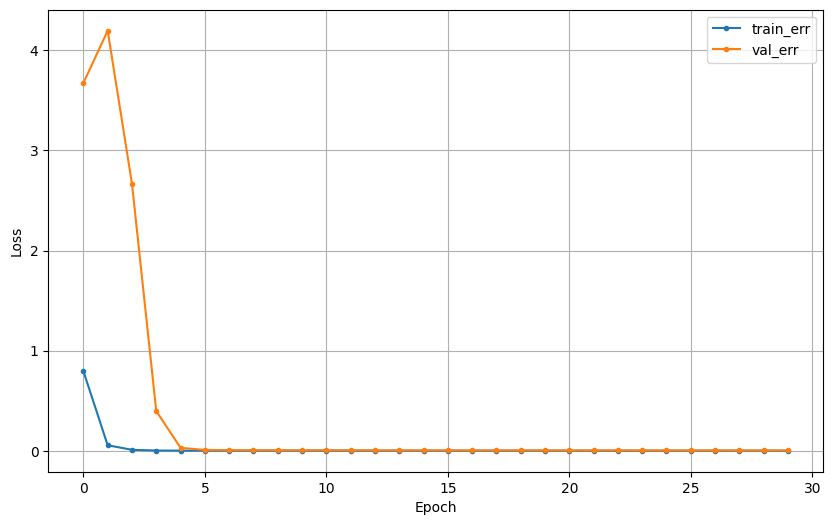

In [23]:
dl_history_plot(history.history)

* 예측 및 검증

In [24]:
y_pred = model.predict(x_test2).argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 11ms/step
0.996


### (2) 모델2

In [25]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    
    keras.backend.clear_session()

    il = keras.layers.Input(shape=(28,28,1))
    cl = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same",activation="relu")(il)
    bl = keras.layers.BatchNormalization()(cl)
    cl2 = keras.layers.Conv2D(filters=32,kernel_size=(2,2),padding="valid",activation="relu")(bl)
    bl2 = keras.layers.BatchNormalization()(cl2)
    cl3 = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu")(bl2)
    bl3 = keras.layers.BatchNormalization()(cl3)
    pl = keras.layers.MaxPool2D(pool_size=(2,2))(bl3)
    cl4 = keras.layers.Conv2D(filters=80,kernel_size=(3,3),padding="same",activation="relu")(pl)
    bl4 = keras.layers.BatchNormalization()(cl4)
    cl5 = keras.layers.Conv2D(filters=192,kernel_size=(2,2),padding="valid",activation="relu")(bl4)
    pl2 = keras.layers.MaxPool2D(pool_size=(2,2))(cl5)

    aver = keras.layers.GlobalAveragePooling2D()(pl2)

    ol = keras.layers.Dense(26,activation = "softmax")(aver)

    model = keras.models.Model(il,ol)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"],optimizer="adam")
    
    es = EarlyStopping(monitor = "val_loss",min_delta=0,patience = 5,verbose=1,restore_best_weights=True)
    history=model.fit(x_train2,y_train,validation_split=0.2,verbose=1,epochs=30,callbacks=[es])
    
    y_pred = model.predict(x_val2).argmax(axis=1)
    acc = accuracy_score(y_val,y_pred)
    mlflow.log_metric("accuracy", acc)
    mlflow.keras.log_model(model, "keras_sign_language",  registered_model_name="DL_sign_language")
    mlflow.keras.autolog(disable = True)

Epoch 1/30
125/125 [==============================] - 4s 24ms/step - loss: 1.3239 - accuracy: 0.6538 - val_loss: 3.6369 - val_accuracy: 0.0690
Epoch 2/30
125/125 [==============================] - 3s 23ms/step - loss: 0.1587 - accuracy: 0.9783 - val_loss: 3.6588 - val_accuracy: 0.0760
Epoch 3/30
125/125 [==============================] - 3s 22ms/step - loss: 0.0297 - accuracy: 0.9995 - val_loss: 2.0182 - val_accuracy: 0.4120
Epoch 4/30
125/125 [==============================] - 3s 22ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.2669 - val_accuracy: 0.9370
Epoch 5/30
125/125 [==============================] - 3s 23ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 0.9940
Epoch 6/30
125/125 [==============================] - 3s 23ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9940
Epoch 7/30
125/125 [==============================] - 3s 22ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9980

INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmpen9o9_2z\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmpen9o9_2z\model\data\model\assets


63/63 [==============================] - 0s 7ms/step


2023/05/18 15:18:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmpdgf82_7h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmpdgf82_7h\model\data\model\assets
Registered model 'DL_sign_language' already exists. Creating a new version of this model...
2023/05/18 15:18:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL_sign_language, version 3
Created version '3' of model 'DL_sign_language'.


* 학습곡선

* 예측 및 검증

In [27]:
keras.backend.clear_session()

il = keras.layers.Input(shape=(28,28,1))
hl = keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="valid",activation="swish")(il)
bl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="swish")(bl)
bl = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bl)
    
hl = keras.layers.AveragePooling2D(pool_size=(2,2))(dl)
    
hl = keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="valid",activation="swish")(hl)
bl = keras.layers.BatchNormalization()(hl)
hl = keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="swish")(bl)
bl = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bl)
    
hl = keras.layers.AveragePooling2D(pool_size=(2,2))(dl)

aver = keras.layers.GlobalAveragePooling2D()(hl)

ol = keras.layers.Dense(26,activation = "softmax")(aver)

model = keras.models.Model(il,ol)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"],optimizer="adam")
model.summary()
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 26, 26, 64)        0     

In [28]:
with mlflow.start_run(experiment_id=exp_id):
    mlflow.keras.autolog()
    
    keras.backend.clear_session()

    il = keras.layers.Input(shape=(28,28,1))
    hl = keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="valid",activation="swish")(il)
    bl = keras.layers.BatchNormalization()(hl)
    hl = keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="swish")(bl)
    bl = keras.layers.BatchNormalization()(hl)
    dl = keras.layers.Dropout(0.2)(bl)
    
    hl = keras.layers.AveragePooling2D(pool_size=(2,2))(dl)
    
    hl = keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="valid",activation="swish")(hl)
    bl = keras.layers.BatchNormalization()(hl)
    hl = keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="swish")(bl)
    bl = keras.layers.BatchNormalization()(hl)
    dl = keras.layers.Dropout(0.2)(bl)
    
    hl = keras.layers.AveragePooling2D(pool_size=(2,2))(dl)

    aver = keras.layers.GlobalAveragePooling2D()(hl)

    ol = keras.layers.Dense(26,activation = "softmax")(aver)

    model = keras.models.Model(il,ol)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"],optimizer="adam")
    
    es = EarlyStopping(monitor = "val_loss",min_delta=0,patience = 5,verbose=1,restore_best_weights=True)
    history=model.fit(x_train2,y_train,validation_split=0.2,verbose=1,epochs=30,callbacks=[es])
    
    y_pred = model.predict(x_val2).argmax(axis=1)
    acc = accuracy_score(y_val,y_pred)
    mlflow.log_metric("accuracy", acc)
    mlflow.keras.log_model(model, "keras_sign_language",  registered_model_name="DL_sign_language")
    mlflow.keras.autolog(disable = True)

Epoch 1/30
125/125 [==============================] - 11s 74ms/step - loss: 2.9560 - accuracy: 0.1830 - val_loss: 3.4169 - val_accuracy: 0.0430
Epoch 2/30
125/125 [==============================] - 9s 72ms/step - loss: 2.3799 - accuracy: 0.3808 - val_loss: 3.8410 - val_accuracy: 0.0410
Epoch 3/30
125/125 [==============================] - 9s 73ms/step - loss: 1.7720 - accuracy: 0.5938 - val_loss: 4.8738 - val_accuracy: 0.0350
Epoch 4/30
125/125 [==============================] - 9s 72ms/step - loss: 1.2583 - accuracy: 0.7628 - val_loss: 4.4535 - val_accuracy: 0.0860
Epoch 5/30
125/125 [==============================] - 9s 73ms/step - loss: 0.9067 - accuracy: 0.8547 - val_loss: 2.4716 - val_accuracy: 0.3020
Epoch 6/30
125/125 [==============================] - 9s 72ms/step - loss: 0.6695 - accuracy: 0.9040 - val_loss: 1.4170 - val_accuracy: 0.6010
Epoch 7/30
125/125 [==============================] - 9s 72ms/step - loss: 0.4965 - accuracy: 0.9423 - val_loss: 0.7888 - val_accuracy: 0.783

INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp7jzws7iv\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp7jzws7iv\model\data\model\assets


63/63 [==============================] - 1s 14ms/step


2023/05/18 15:38:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp68gmkh43\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\dufwn\AppData\Local\Temp\tmp68gmkh43\model\data\model\assets
Registered model 'DL_sign_language' already exists. Creating a new version of this model...
2023/05/18 15:38:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL_sign_language, version 4
Created version '4' of model 'DL_sign_language'.


## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가



In [30]:
model_uri = "models:/DL_sign_language/production" 
model2 = mlflow.keras.load_model(model_uri)

In [31]:
y_pred = model2.predict(x_test2).argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 0s 7ms/step
0.998


In [33]:
model_uri = "models:/DL_sign_language/archived" 
model3 = mlflow.keras.load_model(model_uri)

In [34]:
y_pred = model3.predict(x_test2).argmax(axis=1)
print(accuracy_score(y_test,y_pred))

32/32 [==============================] - 1s 17ms/step
0.996
